In [74]:
#imports
import pandas as pd
import numpy as np
#print fractions
import fractions
np.set_printoptions(formatter={'all':lambda x: str(fractions.Fraction(x).limit_denominator())})

url22 = 'https://raw.githubusercontent.com/edgardomunoznajar/dominance_matrix/main/fixture.csv'

df22 = pd.read_csv(url22)
df22 = df22.rename(columns={"Away Teams": "Away"})
from matplotlib import pyplot as plt

In [75]:
url21 = 'https://raw.githubusercontent.com/edgardomunoznajar/dominance_matrix/main/fixture%20_2021.csv'

df21= pd.read_csv(url21)
df21 = df21.rename(columns={"Away Team": "Away"})
df21


,Round,Date,Home,Away,Crowd,ResultH,ResultA,Goals
0,1,3/18/2023,Richmond,Carlton,49218.0,105,80,J. Riewoldt 4
1,1,3/19/2023,Collingwood,Western Bulldogs,46051.0,53,69,-
2,1,3/20/2023,Melbourne,Fremantle,21365.0,80,58,M. Taberner 3
3,1,3/20/2023,Adelaide,Geelong,26985.0,103,91,T. Walker 5
4,1,3/20/2023,Brisbane,Sydney,22762.0,94,125,-
...,...,...,...,...,...,...,...,...
193,23,8/21/2023,Geelong,Melbourne,NaN,77,81,T. Hawkins 4
194,23,8/21/2023,Carlton,GWS,NaN,75,89,E. Curnow 4
195,23,8/22/2023,St Kilda,Fremantle,3082.0,107,49,C. Sharman 4
196,23,8/22/2023,Essendon,Collingwood,NaN,102,64,J. Elliott 4\nP. Wright 4\nA. Waterman 4


In [133]:


#convert to matrix. 
class dom_calculator:
  def create_dominance_matrix(self,df, round_number):
    # filter the data by round (replace round_number with the desired round number)
    df = df[df['Round'] <= round_number]
    # get the set of all teams
    teams = set(df['Home']).union(set(df['Away']))
    new_index = pd.Index(teams, name='Team')

    df["home_win"] = df.apply(lambda x: self.home_win_value if x["ResultH"] > x["ResultA"] else 0, axis=1)
    df["away_win"] = df.apply(lambda x: self.away_win_value if x["ResultH"] < x["ResultA"] else 0, axis=1)
    df['home_win'] = df.apply(lambda x: 0.5 if x["ResultH"] == x["ResultA"] else x['home_win'], axis=1)
    df['away_win'] = df.apply(lambda x: 0.5 if x["ResultH"] == x["ResultA"] else x['away_win'], axis=1)
    pt_home = pd.pivot_table(data=df, index='Home', columns='Away', values=['home_win'], aggfunc= lambda x: x,fill_value =0)
    
    pt_away = pd.pivot_table(data=df, index='Away', columns='Home', values=['away_win'],aggfunc= lambda x: x, fill_value= 0)
    pt = pt_home.merge(pt_away, left_index=True, right_index=True, how='outer', suffixes=('_home', '_away'))
    pt = pt.groupby(level=1, axis=1).sum()
    # update the diagonal to 0 since a team cannot play against itself
    np.fill_diagonal(pt.values, 0)
    # reindex the pivot table with all teams in alphabetical order
    pt = pt.reindex(index=sorted(pt.index), columns=sorted(pt.columns), fill_value=0)
    self.df = df
    self.pt_shape = pt.shape
    return pt.fillna(0)

  def predict(self,a,b):
    df = self.output
    score_a = df.loc[a]['Score']
    score_b = df.loc[b]['Score']
    return a if score_a>score_b else ('draw' if score_a==score_b else b)

  def predictions(self, df):
    self.df['Prediction'] = df.apply(lambda row: self.predict(row['Home'], row['Away']), axis=1)
    
  def evaluate_future(self):
    self.fr['Prediction'] = self.fr.apply(lambda row: self.predict(row['Home'], row['Away']), axis=1) 
    self.fr['Winner'] = self.fr.apply(lambda x: x['Home'] if x['ResultH'] > x['ResultA'] else x['Away'] if x['ResultH'] < x['ResultA'] else " ", axis=1)
    self.fr['Predicted?'] = self.fr.apply(lambda x: 1 if x['Winner'] == x['Prediction'] else 0, axis=1)
  
  def aggregate_future_rounds(self):
    # Generate a single random color
    single_color = np.random.rand(3)

    self.grouped = self.fr.groupby(['Round'])[["Predicted?"]].sum()
    # calculate the number of rows in each group
    grouped_count = self.fr.groupby('Round').size()
    # divide the sum of each group by the number of rows in that group
    self.result = self.grouped.div(grouped_count, axis=0)
    
    # Reset the index of self.result to include the 'Round' column
    self.result.reset_index(inplace=True)

    # Use the single_color for all data points
    self.ax.scatter(self.result['Round'], self.result['Predicted?'], c=single_color, label=self.label)
    self.result.rename(columns={'Predicted?': self.label}, inplace=True)

  def set_fr(self, fr):
    self.fr = fr

  def __init__(self,ax ,label, df,round, home_win_value, away_win_value, alpha = 1, beta = 0.5,teta = 0):
    self.ax = ax
    self.label = label
    self.df = df
    self.fr = df[df['Round'] > round]
    self.alpha = alpha
    self.beta = beta
    self.teta = teta
    self.round = round
    self.home_win_value = home_win_value
    self.away_win_value = away_win_value
    self.pt = self.create_dominance_matrix(df,self.round)
    self.D  = self.pt.to_numpy()
    self.D_1 = np.full((self.D.shape[1],1), 1)
    self.D_D_1 = np.matmul(self.D,self.D_1)
    self.D_T_D1 = np.matmul(self.D.T, self.D_1)
    self.D_squared = np.matmul(self.D,self.D)
    self.D_cubed = np.matmul(self.D_squared,self.D)
    self.r1 = self.D_D_1 - self.D_T_D1
    self.r2 = np.matmul(self.D_squared,self.D_1)
    self.r3 = np.matmul(self.D_cubed,self.D_1)
    self.r = self.alpha * self.r1 + self.beta*self.r2 + self.teta*self.r3
    self.score = pd.DataFrame(self.r, columns = ['Score'])

    #formating r as a score
    self.output=pd.concat([self.pt.index.to_series().reset_index(drop=True),self.score.reset_index(drop=True)],axis=1).rename(columns={"Home": "Team"}).set_index('Team').sort_values(by=['Score'], ascending=False)
    self.predictions(self.df)
    self.evaluate_future()
    self.aggregate_future_rounds()



<ipython-input-133-10ae73892505>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["home_win"] = df.apply(lambda x: self.home_win_value if x["ResultH"] > x["ResultA"] else 0, axis=1)
<ipython-input-133-10ae73892505>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["away_win"] = df.apply(lambda x: self.away_win_value if x["ResultH"] < x["ResultA"] else 0, axis=1)
<ipython-input-133-10ae73892505>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

(                  Score
 Team                   
 Melbourne          20.5
 Fremantle          16.0
 Brisbane           15.5
 Carlton            12.5
 St Kilda           11.5
 Geelong            10.0
 Sydney              8.0
 Collingwood         6.5
 Richmond            5.0
 Gold Coast          4.0
 Adelaide            3.0
 Port Adelaide       2.5
 Hawthorn            2.5
 Western Bulldogs    2.0
 GWS                -1.0
 Essendon           -1.0
 West Coast         -4.0
 North Melbourne    -5.5,
                   Score
 Team                   
 Melbourne          35.5
 Fremantle          30.5
 Brisbane           30.5
 St Kilda           26.0
 Geelong            20.0
 Carlton            18.0
 Sydney             16.5
 Collingwood        14.5
 Gold Coast         11.5
 Richmond            8.5
 Port Adelaide       8.0
 Adelaide            5.5
 Hawthorn            5.5
 Western Bulldogs    3.0
 GWS                 0.5
 Essendon           -3.0
 West Coast         -3.0
 North Melbourne    -7.0

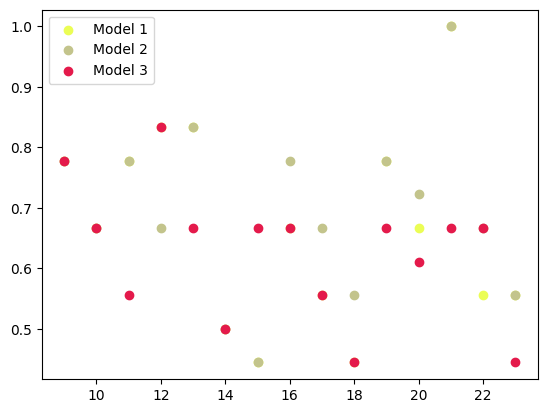

In [134]:
fig, ax = plt.subplots()

#Usage: self,ax ,label, df,round, home_win_value, away_win_value, alpha = 1, beta = 0.5,teta = 0):
d0 = dom_calculator(ax,'Model 1',df22,8,1,1)
d1 = dom_calculator(ax,'Model 2',df22, 8,1,2)
d2 = dom_calculator(ax,'Model 3', df22, 8,4,1,1,0.5,0.1)
ax.legend()

d0.output,d1.output,d2.output

In [113]:
results = [d0.result, d1.result, d2.result]  # Add more results as needed

# Concatenate the DataFrames in the list into a single DataFrame
combined_result = pd.concat(results, axis=1, ignore_index=False)

# Identify the extra 'Round' columns
extra_round_columns = combined_result.columns[combined_result.columns.str.startswith('Round')][1:]

# Drop the extra 'Round' columns
combined_result.drop(columns=extra_round_columns, inplace=True)

# Round the predicted columns to two decimal places
combined_result = combined_result.round(2)

combined_result

,Model 1,Model 2,Model 3
0,0.78,0.78,0.78
1,0.67,0.67,0.67
2,0.78,0.78,0.56
3,0.83,0.67,0.83
4,0.83,0.83,0.67
5,0.50,0.50,0.50
6,0.44,0.44,0.67
7,0.67,0.78,0.67
8,0.56,0.67,0.56
9,0.44,0.56,0.44


In [114]:
combined_result.to_csv('combined_result.csv')

<ipython-input-97-fae772c1de4f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["home_win"] = df.apply(lambda x: self.home_win_value if x["ResultH"] > x["ResultA"] else 0, axis=1)
<ipython-input-97-fae772c1de4f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["away_win"] = df.apply(lambda x: self.away_win_value if x["ResultH"] < x["ResultA"] else 0, axis=1)
<ipython-input-97-fae772c1de4f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

(     Round       Date         Home              Away    Crowd  ResultH  \
 0        1  3/18/2023     Richmond           Carlton  49218.0      105   
 1        1  3/19/2023  Collingwood  Western Bulldogs  46051.0       53   
 2        1  3/20/2023    Melbourne         Fremantle  21365.0       80   
 3        1  3/20/2023     Adelaide           Geelong  26985.0      103   
 4        1  3/20/2023     Brisbane            Sydney  22762.0       94   
 ..     ...        ...          ...               ...      ...      ...   
 193     23  8/21/2023      Geelong         Melbourne      NaN       77   
 194     23  8/21/2023      Carlton               GWS      NaN       75   
 195     23  8/22/2023     St Kilda         Fremantle   3082.0      107   
 196     23  8/22/2023     Essendon       Collingwood      NaN      102   
 197     23  8/22/2023     Adelaide   North Melbourne  13103.0       98   
 
      ResultA                                     Goals  
 0         80                           

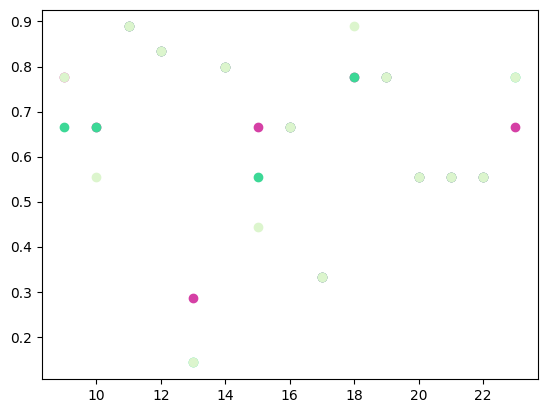

In [122]:
fig, ax = plt.subplots()

#improving the model: Double Away wins, 0.2 for r3
d3 = dom_calculator(ax,'Basic',df21,8,1,1)
d4 = dom_calculator(ax,'Double value for Away',df21, 8,1,2)
d5 = dom_calculator(ax,'Increase weight of r2 and r3', df21, 8,1,1,1,1,0.5)
df21, d0.output,d1.output,d2.output

array([[121/2],
       [126],
       [131/2],
       [54],
       [159/2],
       [82],
       [431/4],
       [297/2],
       [119/2],
       [335/4],
       [681/4],
       [151/4],
       [261/2],
       [169/2],
       [165/2],
       [138],
       [169/2],
       [139]])

In [118]:
results = [d0.result, d1.result, d2.result]  # Add more results as needed

# Concatenate the DataFrames in the list into a single DataFrame
combined_result = pd.concat(results, axis=1, ignore_index=False)

# Identify the extra 'Round' columns
extra_round_columns = combined_result.columns[combined_result.columns.str.startswith('Round')][1:]

# Drop the extra 'Round' columns
combined_result.drop(columns=extra_round_columns, inplace=True)

# Round the predicted columns to two decimal places
combined_result = combined_result.round(2)
combined_result.to_csv('combined_result21.csv')
combined_result

,Basic,Double value for Away,Increase weight of r2 and r3
0,0.78,0.67,0.78
1,0.67,0.67,0.56
2,0.89,0.89,0.89
3,0.83,0.83,0.83
4,0.29,0.14,0.14
5,0.80,0.80,0.80
6,0.67,0.56,0.44
7,0.67,0.67,0.67
8,0.33,0.33,0.33
9,0.78,0.78,0.89


In [151]:
url23 = 'https://raw.githubusercontent.com/edgardomunoznajar/dominance_matrix/main/fixture_2023.csv'

df23= pd.read_csv(url23)
df23 = df23.rename(columns={"Away Teams": "Away"})
df23 = df23.rename(columns={"Unnamed: 0":"Round"})
df23


,Round,Date,Home,Away,Crowd,ResultH,ResultA,Goals
0,1,Thu 16 Mar 7:20 PM,Richmond,Carlton,88084.0,58,58,T. Lynch 3\nC. Curnow 3
1,1,Fri 17 Mar 7:40 PM,Geelong,Collingwood,86595.0,103,125,J. De Goey 3\nB. Hill 3
2,1,Sat 18 Mar 1:45 PM,North Melbourne,West Coast,21274.0,87,82,N. Larkey 6
3,1,Sat 18 Mar 4:05 PM,Port Adelaide,Brisbane,34255.0,126,72,T. Marshall 4
4,1,Sat 18 Mar 7:00 PM,Gold Coast,Sydney,13648.0,61,110,-
5,1,Sat 18 Mar 7:25 PM,Melbourne,Western Bulldogs,48103.0,115,65,B. Brown 4\nK. Pickett 4
6,1,Sun 19 Mar 1:10 PM,GWS,Adelaide,8169.0,106,90,T. Greene 4
7,1,Sun 19 Mar 3:20 PM,Hawthorn,Essendon,68691.0,65,124,L. Breust 3\nA. Perkins 3
8,1,Sun 19 Mar 4:40 PM,St Kilda,Fremantle,23429.0,67,52,-
9,2,Thu 23 Mar 7:20 PM,Carlton,Geelong,55861.0,90,82,J. Cameron 6


In [152]:
d1.set_fr(df23)
d1.fr
d1.evaluate_future()
d1.aggregate_future_rounds()
d1.result

,Round,Model 2
0,1,0.222222
1,2,0.444444
2,3,0.666667
